<a href="https://colab.research.google.com/github/mateosuster/nlpPapers/blob/main/10_LDA_TopicModels_GENSIM_EVOLUCION_ANUAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencias

In [1]:
%%capture
!pip install pyLDAvis==2.1.2

import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
from collections import Counter


from nltk import word_tokenize, sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim import corpora

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import os, re, operator, warnings
warnings.filterwarnings('ignore')  
%matplotlib inline

# **LDA: MODEL 1:** ***19 Topics***

In [2]:
### LDA TOPICS:
# params
Tipo_Datos_ = "sampleados"  ### INGRESE DATOS A UTILIZAR: ELIJA: "totales" O "sampleados".
Cant_Optima_Topics = 19     ### INGRESE CANT. OPTIMA DE TOPICOS. 

# data
from pandas.core.describe import describe_categorical_1d
data_Total = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/ACL_data.csv")
data_Sampleada = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/data_clean.csv")
data_Total_con_Gender_Year = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/data_gender_abstract_year.csv")

if Tipo_Datos_ == "sampleados":
  data = data_Sampleada
elif Tipo_Datos_ == "totales":
  data = data_Total

if Tipo_Datos_ == "sampleados":
  dataset = data.text.tolist()
elif Tipo_Datos_ == "totales":
  dataset = data.ABSTRACT
  dataset = dataset.tolist()

#cleaning
STOP_WORDS = stopwords.words("english")

def tokenize(x):
    return [word for word in word_tokenize(x) if word not in STOP_WORDS and word.isalpha() and len(word)>1]

if Tipo_Datos_ == "sampleados":
  texts = [word_tokenize(str(doc)) for doc in dataset]
elif Tipo_Datos_ == "totales":
  texts= [tokenize(str(doc).lower()) for doc in dataset]

#dictionaries
dictionary = corpora.Dictionary(texts)  #crea diccionario asinandole un indice numerico a cada palabra
dictionary.filter_extremes(no_below=10, no_above=0.5)  #filtra tokens q aparencen en menos de 10 documentos y en mas de la mitad de los documentos.

### doc2bow:
corpus = [dictionary.doc2bow(text) for text in texts] #el bow cuenta cantidad de apariciones de cada palabra del diccionario

#### SETEO DE SEMILLA:
semilla = 420
np.random.seed(semilla)

# LDA realizado con el doc2bow (bolsa de palabras comun)  (NO con TF-IDF):
ldamodel_optimo = LdaModel(corpus=corpus, num_topics=Cant_Optima_Topics, id2word=dictionary, iterations = 200, passes=10, random_state=semilla)

#### COHERENCIAS TOTALES DEL MODELO:
window_size_=10     # INGRESE COHERENCIA WINDOW_SIZE 
coherence_='c_npmi' # INGRESE METRICA DE COHERENCIA 
topn_=30            # INGRESE COHERENCIA TOP WORDS TO EVALUATE. 

ldatopics_optimo = [[word for word, prob in topic] for topicid, topic in ldamodel_optimo.show_topics(Cant_Optima_Topics,formatted=False)]
lda_coherence = CoherenceModel(topics=ldatopics_optimo, texts=texts, dictionary=dictionary, window_size=window_size_,coherence=coherence_,topn=topn_).get_coherence_per_topic()
df_lda = pd.DataFrame([range(Cant_Optima_Topics),lda_coherence,ldatopics_optimo],index=['topic_id','coherence','topic']).transpose()

Coherence_Total = (sum(lda_coherence))
Coherence_Media = (np.mean(lda_coherence))
Coherence_Media_Ponderada = Coherence_Media/ Coherence_Total 

print('Nro. Topics Optimo: %.2f ' % (Cant_Optima_Topics))
print('Coherencia Media: %.2f ' % (round(Coherence_Total,2)))
print('Coherencia Total: %.2f ' % (round(Coherence_Media,2)))
print('Coherencia Media Pond: %.2f ' % (round(Coherence_Media_Ponderada,2)))
print(" ")

### GRAFICO DE TOPICOS DEL MODELO:
pyLDAvis.gensim.prepare(ldamodel_optimo, corpus, dictionary)

Nro. Topics Optimo: 19.00 
Coherencia Media: 1.69 
Coherencia Total: 0.09 
Coherencia Media Pond: 0.05 
 


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16     0.160435 -0.092294       1        1  21.189173
15     0.150458 -0.151530       2        1   9.941970
18     0.080075  0.081806       3        1   7.796165
1      0.089298  0.018408       4        1   7.352687
4      0.088220 -0.078706       5        1   5.590065
5      0.090404  0.011600       6        1   5.326612
7      0.098066 -0.000696       7        1   5.155809
17     0.103013  0.020528       8        1   5.063244
8      0.056585  0.023908       9        1   4.770171
9     -0.345742 -0.111927      10        1   4.503112
14     0.097517 -0.127329      11        1   4.399415
0      0.092350 -0.180551      12        1   3.688992
11    -0.020909  0.227372      13        1   3.485621
10     0.018812  0.172148      14        1   2.999573
12    -0.009121  0.164427      15        1   2.502339
13    -0.040340  0.162271      16        1   2.434244
3     -0.137851 -0.030430      17        1   1.884343
2     -0.204952 -0.076002      18        1   1.174642
6     -0.366318 -0.033003      19        1   0.741824, topic_info=              Term          Freq         Total Category  logprob  loglift
747    translation   6910.000000   6910.000000  Default  30.0000  30.0000
3526            de   5742.000000   5742.000000  Default  29.0000  29.0000
645           word   5009.000000   5009.000000  Default  28.0000  28.0000
209       language  12909.000000  12909.000000  Default  27.0000  27.0000
168          model  14504.000000  14504.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
399        comment    113.629949    155.667661  Topic19  -4.5254   4.5890
1240       entries    109.713540    251.189797  Topic19  -4.5605   4.0755
1489  performances    112.323779    378.965312  Topic19  -4.5370   3.6878
3919          unit     90.762661    195.848548  Topic19  -4.7501   4.1347
6370           non     76.706392    141.142221  Topic19  -4.9184   4.2940

[1204 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
3975      2  0.989416         absa
1807      9  0.993899  abstractive
647       4  0.990678        abuse
44       17  0.988259      abusive
2060      3  0.966853     academic
...     ...       ...          ...
499      17  0.025058      written
5187     16  0.993312          wsd
1931      5  0.858121         year
1931      9  0.115962         year
1931     13  0.023192         year

[3117 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 16, 19, 2, 5, 6, 8, 18, 9, 10, 15, 1, 12, 11, 13, 14, 4, 3, 7])

In [ ]:
df_lda.sort_values(by='topic_id',ascending=True)

,topic_id,coherence,topic
0,0,0.046422,"[data, training, emotion, labels, learning, cl..."
1,1,0.034452,"[dialogue, user, human, systems, users, system..."
2,2,0.169227,"[speech, error, recognition, errors, automatic..."
3,3,0.156955,"[social, media, detection, sentiment, tweets, ..."
4,4,0.02931,"[task, system, paper, model, shared, results, ..."
5,5,0.040916,"[languages, data, language, multilingual, engl..."
6,6,0.082519,"[diff, rentes, tude, peut, leur, propos, rents..."
7,7,0.112279,"[translation, machine, mt, system, evaluation,..."
8,8,0.063901,"[corpus, news, discourse, event, text, documen..."
9,9,0.396952,"[de, des, la, les, et, un, le, nous, une, en]"


# **LDA: MODEL 2:** ***32 Topics***

In [91]:
##### LDA TOPICS:
### params
Tipo_Datos_ = "sampleados"  ### INGRESE DATOS A UTILIZAR: ELIJA: "totales" O "sampleados".
Cant_Optima_Topics = 32    #50 #40 #33 ##32     ### INGRESE CANT. OPTIMA DE TOPICOS. 

### DATA
from pandas.core.describe import describe_categorical_1d
data_Total = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/ACL_data.csv")
data_Sampleada = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/data_clean.csv")
data_Total_con_Gender_Year = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/data_gender_abstract_year.csv")
#Table_Topics_32_Tags = pd.read_excel("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/TOPICS_32_TAGS_v2.xlsx")
Table_Topics_32_Tags = pd.read_excel("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/TOPICS_32_TAGS_v3.xlsx")


if Tipo_Datos_ == "sampleados":
  data = data_Sampleada
elif Tipo_Datos_ == "totales":
  data = data_Total

if Tipo_Datos_ == "sampleados":
  dataset = data.text.tolist()
elif Tipo_Datos_ == "totales":
  dataset = data.ABSTRACT
  dataset = dataset.tolist()

#cleaning
STOP_WORDS = stopwords.words("english")

def tokenize(x):
    return [word for word in word_tokenize(x) if word not in STOP_WORDS and word.isalpha() and len(word)>1]

if Tipo_Datos_ == "sampleados":
  texts = [word_tokenize(str(doc)) for doc in dataset]
elif Tipo_Datos_ == "totales":
  texts= [tokenize(str(doc).lower()) for doc in dataset]

#dictionaries
dictionary = corpora.Dictionary(texts)  #crea diccionario asinandole un indice numerico a cada palabra
dictionary.filter_extremes(no_below=10, no_above=0.5)  #filtra tokens q aparencen en menos de 10 documentos y en mas de la mitad de los documentos.

### doc2bow:
corpus = [dictionary.doc2bow(text) for text in texts] #el bow cuenta cantidad de apariciones de cada palabra del diccionario

#### SETEO DE SEMILLA:
semilla = 420  #666 #777 #421 ##420
np.random.seed(semilla)

# LDA realizado con el doc2bow (bolsa de palabras comun)  (NO con TF-IDF):
ldamodel_optimo2 = LdaModel(corpus=corpus, num_topics=Cant_Optima_Topics, id2word=dictionary, iterations = 200, passes=10, random_state=semilla)

#### COHERENCIAS TOTALES DEL MODELO:
window_size_=10     # INGRESE COHERENCIA WINDOW_SIZE 
coherence_='c_npmi' # INGRESE METRICA DE COHERENCIA 
topn_=30            # INGRESE COHERENCIA TOP WORDS TO EVALUATE. 

ldatopics_optimo2 = [[word for word, prob in topic] for topicid, topic in ldamodel_optimo2.show_topics(Cant_Optima_Topics,formatted=False)]
lda_coherence2 = CoherenceModel(topics=ldatopics_optimo2, texts=texts, dictionary=dictionary, window_size=window_size_,coherence=coherence_,topn=topn_).get_coherence_per_topic()
df_lda2 = pd.DataFrame([range(Cant_Optima_Topics),lda_coherence2,ldatopics_optimo2],index=['topic_id','coherence','topic']).transpose()

Coherence_Total = (sum(lda_coherence2))
Coherence_Media = (np.mean(lda_coherence2))
Coherence_Media_Ponderada = Coherence_Media/ Coherence_Total 

print('Nro. Topics Optimo: %.2f ' % (Cant_Optima_Topics))
print('Coherencia Media: %.2f ' % (round(Coherence_Total,2)))
print('Coherencia Media Pond: %.2f ' % (round(Coherence_Media,2)))
#print('Coherencia Media Pond: %.2f ' % (round(Coherence_Media_Ponderada,2)))
print(" ")

### GRAFICO DE TOPICOS DEL MODELO:
pyLDAvis.gensim.prepare(ldamodel_optimo2, corpus, dictionary)

Nro. Topics Optimo: 32.00 
Coherencia Media: 1.59 
Coherencia Media Pond: 0.05 
 


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16     0.208013  0.073254       1        1  17.809913
27     0.164168  0.146732       2        1   8.377809
1      0.144311 -0.029004       3        1   6.677804
18     0.093843 -0.138354       4        1   4.942024
19     0.154726  0.126873       5        1   4.351324
9     -0.257431  0.008990       6        1   4.284890
31     0.139496 -0.040773       7        1   4.258588
29     0.101111 -0.042590       8        1   4.127451
15     0.145521  0.208517       9        1   3.604036
22     0.089013 -0.172553      10        1   3.523853
5      0.141230 -0.058388      11        1   3.510307
28     0.103182 -0.230392      12        1   3.155321
7      0.096055 -0.032287      13        1   3.144904
4      0.066648 -0.074032      14        1   2.873878
8      0.061174 -0.079387      15        1   2.467092
17     0.077652  0.059263      16        1   2.458153
14     0.043993  0.144670      17        1   2.385386
11    -0.021537 -0.189846      18        1   1.883278
0      0.072514  0.119535      19        1   1.634557
24    -0.063363 -0.001597      20        1   1.604726
13    -0.109245 -0.044366      21        1   1.540338
2     -0.072026 -0.052624      22        1   1.534175
26    -0.035993  0.102254      23        1   1.462747
23    -0.047734  0.013618      24        1   1.347617
25    -0.052277  0.090711      25        1   1.244213
10    -0.074201 -0.093895      26        1   1.091769
3     -0.180196 -0.128735      27        1   1.002577
12    -0.085765  0.118195      28        1   0.966300
21    -0.162722  0.025626      29        1   0.941554
6     -0.272766  0.005826      30        1   0.655857
30    -0.258356  0.056171      31        1   0.588509
20    -0.209040  0.108585      32        1   0.549050, topic_info=             Term          Freq         Total Category  logprob  loglift
747   translation   6411.000000   6411.000000  Default  30.0000  30.0000
645          word   4798.000000   4798.000000  Default  29.0000  29.0000
3526           de   5693.000000   5693.000000  Default  28.0000  28.0000
208     knowledge   4754.000000   4754.000000  Default  27.0000  27.0000
209      language  12907.000000  12907.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
1061       robust    108.016348    647.231492  Topic32  -4.2751   3.4143
1938        noise     78.584462    447.205545  Topic32  -4.5932   3.4659
959     sensitive     68.698751    200.390864  Topic32  -4.7277   4.1342
635         input     71.705382   2161.539386  Topic32  -4.6849   1.7987
1591      example     62.489222    676.851584  Topic32  -4.8224   2.8223

[1891 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
893       1  0.250833  ability
893       2  0.010731  ability
893       3  0.122063  ability
893       5  0.008048  ability
893       8  0.327290  ability
...     ...       ...      ...
538      12  0.029006    years
538      13  0.033586    years
538      22  0.045799    years
538      24  0.015266    years
848      19  0.976489  youtube

[5115 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 28, 2, 19, 20, 10, 32, 30, 16, 23, 6, 29, 8, 5, 9, 18, 15, 12, 1, 25, 14, 3, 27, 24, 26, 11, 4, 13, 22, 7, 31, 21])

### ***Analisis Cualitativo de Tópicos:***
#### ***Topicos n=32***
##### Cuadrante I 

**Frances** <br>
3 Papers en frances <br>
19 Papers en frances + ruido <br>
<br>


##### Cuadrante II

**Modelos del lenguaje**

1 Language Models <br>
2 Language Models - Embeddings, commonsense <br>
6 Clasification tasks? <br>

18 seq2seq <br>
14 Multilingual Neural Machine Translation (NMT) <br>
21  Adversarial contrastive learning + kg <br>
<br>

##### Cuadrante III
**Sentiments** <br>
20 Sentimental analysis <br>
23 Analysis de tweets (hater speach) <br> <br>

**Transformers** <br>
22 Transformes + social media <br> <br>

26 Pos tagging <br> <br>

25 eventos temporales <br>
24 Dialogue response

32 SVM / Ensambles <br>
27 arabic segmentation <br>
31 Universal Dependencies (UD) <br>

29 Ruido / Out-of-Domain(OOD)

<br> <br>
##### Cuadrante IV
**Semantics / Embedings** <br>
4 Multimodal <br>
5 World similarity / Analisis Semántico <br>
8 Sumarization <br>
11 Machine Translation <br> <br>

7 NLP community advances ? <br>
9 Modelos multilingual / BERT <br>
10 Systems learning tasks? <br> <br>
 
14 automatic speach recognition (asr) <br> 
16  a knowledge graph (KG) <br>
17 analisis sintactico del discurso <br> <br>

13 Anotacion de corpus <br>
12 Procesamiento historias clinicas / biomedicas





In [ ]:
df_lda2.sort_values(by='topic_id',ascending=True)
"""
topic_id	coherence	topic
0	0	-0.229137	[relations, discourse, relation, claims, units...
1	1	-0.428925	[simplification, readers, ud, patients, misogy...
2	2	0.073514	[languages, language, multilingual, tasks, tra...
3	3	0.06152	[dataset, detection, social, news, text, class...
4	4	0.068299	[word, embeddings, words, sentiment, similarit...
5	5	0.045333	[evaluation, human, study, metrics, linguistic...
6	6	-0.003495	[shared, task, tweets, team, offensive, causal...
7	7	0.179499	[question, reasoning, questions, answering, an...
8	8	-0.192432	[transformer, conversations, transformers, ber...
9	9	-0.10631	[events, expressions, temporal, time, platform...
10	10	-0.076344	[knowledge, multimodal, ner, image, commonsens...
11	11	-0.214767	[et, argument, comments, al, arguments, prompt...
12	12	-0.17166	[summarization, summaries, architectures, impl...
13	13	0.073846	[information, extraction, graph, text, documen...
14	14	0.071262	[parsing, dependency, syntactic, semantic, eve...
15	15	0.045787	[corpus, speech, data, corpora, annotated, pap...
16	16	0.345143	[de, la, des, les, et, le, un, une, en, nous]
17	17	0.0431	[dialogue, data, domain, domains, labeled, res...
18	18	0.102047	[translation, machine, mt, parallel, nmt, alig...
19	19	-0.33508	[samples, qualitative, compression, messages, ...
20	20	0.010441	[system, english, paper, evaluation, results, ...
21	21	0.020131	[annotation, media, annotations, data, feedbac...
22	22	0.024803	[task, system, paper, systems, dataset, score,...
23	23	-0.038536	[entity, entities, named, recognition, ensembl...
24	24	-0.312944	[interpretation, japanese, simultaneous, menti...
25	25	0.123969	[language, nlp, research, processing, data, na...
26	26	0.031872	[embedding, inference, approach, labels, algor...
27	27	0.077539	[neural, network, model, state, emotion, deep,...
28	28	0.05527	[model, propose, models, datasets, training, p...
29	29	-0.023111	[downstream, lexical, semantic, encoder, lexic...
30	30	-0.10377	[biomedical, negative, tagging, probing, pos, ...
31	31	0.062788	[models, model, language, learning, performanc..."""

'\ntopic_id\tcoherence\ttopic\n0\t0\t-0.229137\t[relations, discourse, relation, claims, units...\n1\t1\t-0.428925\t[simplification, readers, ud, patients, misogy...\n2\t2\t0.073514\t[languages, language, multilingual, tasks, tra...\n3\t3\t0.06152\t[dataset, detection, social, news, text, class...\n4\t4\t0.068299\t[word, embeddings, words, sentiment, similarit...\n5\t5\t0.045333\t[evaluation, human, study, metrics, linguistic...\n6\t6\t-0.003495\t[shared, task, tweets, team, offensive, causal...\n7\t7\t0.179499\t[question, reasoning, questions, answering, an...\n8\t8\t-0.192432\t[transformer, conversations, transformers, ber...\n9\t9\t-0.10631\t[events, expressions, temporal, time, platform...\n10\t10\t-0.076344\t[knowledge, multimodal, ner, image, commonsens...\n11\t11\t-0.214767\t[et, argument, comments, al, arguments, prompt...\n12\t12\t-0.17166\t[summarization, summaries, architectures, impl...\n13\t13\t0.073846\t[information, extraction, graph, text, documen...\n14\t14\t0.071262\t

In [92]:
#df_lda2.sort_values(by='topic_id',ascending=True)
df_lda2.sort_values(by='coherence',ascending=False)

,topic_id,coherence,topic
9,9,0.396959,"[de, des, la, les, et, un, le, nous, une, en]"
0,0,0.178945,"[question, questions, answering, answer, qa, a..."
7,7,0.163702,"[translation, machine, mt, system, quality, sy..."
24,24,0.151279,"[parsing, semantic, syntactic, dependency, par..."
23,23,0.149625,"[sentiment, analysis, opinion, news, aspect, p..."
25,25,0.121949,"[documents, document, summarization, style, su..."
26,26,0.11813,"[entity, named, entities, retrieval, search, r..."
18,18,0.106076,"[research, language, nlp, processing, paper, t..."
29,29,0.086882,"[language, models, natural, linguistic, repres..."
13,13,0.066504,"[word, words, embeddings, dictionary, sense, c..."


In [ ]:
df_lda2

,topic_id,coherence,topic
0,0,0.178945,"[question, questions, answering, answer, qa, a..."
1,1,0.0334,"[evaluation, human, metrics, study, models, wo..."
2,2,0.045277,"[social, media, detection, errors, error, heal..."
3,3,0.059193,"[speech, arabic, recognition, spoken, automati..."
4,4,0.049652,"[system, user, users, systems, framework, arch..."
5,5,0.059421,"[languages, multilingual, language, data, doma..."
6,6,-0.020837,"[diff, lexique, non, rentes, tude, peut, leur,..."
7,7,0.163702,"[translation, machine, mt, system, quality, sy..."
8,8,0.055724,"[texts, text, articles, dataset, features, new..."
9,9,0.396959,"[de, des, la, les, et, un, le, nous, une, en]"


In [ ]:
df_lda2.to_csv('topic32_x.csv')

# **LDA: MODEL 3:** ***16 Topics***

In [4]:
### LDA TOPICS:
# params
Tipo_Datos_ = "sampleados"  ### INGRESE DATOS A UTILIZAR: ELIJA: "totales" O "sampleados".
Cant_Optima_Topics = 16     ### INGRESE CANT. OPTIMA DE TOPICOS. 

# data
from pandas.core.describe import describe_categorical_1d
data_Total = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/ACL_data.csv")
data_Sampleada = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/data_clean.csv")
data_Total_con_Gender_Year = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/data_gender_abstract_year.csv")

if Tipo_Datos_ == "sampleados":
  data = data_Sampleada
elif Tipo_Datos_ == "totales":
  data = data_Total

if Tipo_Datos_ == "sampleados":
  dataset = data.text.tolist()
elif Tipo_Datos_ == "totales":
  dataset = data.ABSTRACT
  dataset = dataset.tolist()

#cleaning
STOP_WORDS = stopwords.words("english")

def tokenize(x):
    return [word for word in word_tokenize(x) if word not in STOP_WORDS and word.isalpha() and len(word)>1]

if Tipo_Datos_ == "sampleados":
  texts = [word_tokenize(str(doc)) for doc in dataset]
elif Tipo_Datos_ == "totales":
  texts= [tokenize(str(doc).lower()) for doc in dataset]

#dictionaries
dictionary = corpora.Dictionary(texts)  #crea diccionario asinandole un indice numerico a cada palabra
dictionary.filter_extremes(no_below=10, no_above=0.5)  #filtra tokens q aparencen en menos de 10 documentos y en mas de la mitad de los documentos.

### doc2bow:
corpus = [dictionary.doc2bow(text) for text in texts] #el bow cuenta cantidad de apariciones de cada palabra del diccionario

#### SETEO DE SEMILLA:
semilla = 420
np.random.seed(semilla)

# LDA realizado con el doc2bow (bolsa de palabras comun)  (NO con TF-IDF):
ldamodel_optimo3 = LdaModel(corpus=corpus, num_topics=Cant_Optima_Topics, id2word=dictionary, iterations = 200, passes=10, random_state=semilla)

#### COHERENCIAS TOTALES DEL MODELO:
window_size_=10     # INGRESE COHERENCIA WINDOW_SIZE 
coherence_='c_npmi' # INGRESE METRICA DE COHERENCIA 
topn_=30            # INGRESE COHERENCIA TOP WORDS TO EVALUATE. 

ldatopics_optimo3 = [[word for word, prob in topic] for topicid, topic in ldamodel_optimo3.show_topics(Cant_Optima_Topics,formatted=False)]
lda_coherence3 = CoherenceModel(topics=ldatopics_optimo3, texts=texts, dictionary=dictionary, window_size=window_size_,coherence=coherence_,topn=topn_).get_coherence_per_topic()
df_lda3 = pd.DataFrame([range(Cant_Optima_Topics),lda_coherence3,ldatopics_optimo3],index=['topic_id','coherence','topic']).transpose()

Coherence_Total = (sum(lda_coherence3))
Coherence_Media = (np.mean(lda_coherence3))
Coherence_Media_Ponderada = Coherence_Media/ Coherence_Total 

print('Nro. Topics Optimo: %.2f ' % (Cant_Optima_Topics))
print('Coherencia Total: %.2f ' % (round(Coherence_Total,2)))
print('Coherencia Media: %.2f ' % (round(Coherence_Media,2)))
#print('Coherencia Media Pond: %.2f ' % (round(Coherence_Media_Ponderada,2)))
print(" ")

### GRAFICO DE TOPICOS DEL MODELO:
pyLDAvis.gensim.prepare(ldamodel_optimo3, corpus, dictionary)

Nro. Topics Optimo: 16.00 
Coherencia Total: 1.40 
Coherencia Media: 0.09 
 


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.168141  0.069662       1        1  13.390354
5     -0.148489  0.026408       2        1  12.447003
15    -0.149054  0.095550       3        1  10.657214
1     -0.095661 -0.015129       4        1   8.935997
8     -0.053511 -0.032470       5        1   6.742525
4     -0.068869 -0.022849       6        1   6.200108
7     -0.088919 -0.011057       7        1   6.092422
10    -0.000022 -0.107461       8        1   5.839863
14    -0.140423  0.092486       9        1   5.753440
12    -0.040231 -0.019227      10        1   5.380303
6      0.011245 -0.061781      11        1   4.851712
9      0.387952  0.345261      12        1   4.612994
13     0.042274 -0.011103      13        1   2.719945
11     0.102952 -0.027031      14        1   2.672550
2      0.072329 -0.054779      15        1   2.281222
3      0.336569 -0.266482      16        1   1.422350, topic_info=             Term          Freq         Total Category  logprob  loglift
747   translation   6853.000000   6853.000000  Default  30.0000  30.0000
3526           de   5774.000000   5774.000000  Default  29.0000  29.0000
645          word   4600.000000   4600.000000  Default  28.0000  28.0000
39           task   9221.000000   9221.000000  Default  27.0000  27.0000
144          data  10832.000000  10832.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
628        corpus    573.351832   5216.899294  Topic16  -3.5578   2.0447
2746       verbal    132.757293    185.195747  Topic16  -5.0208   3.9200
2483      speaker    156.174402    294.040438  Topic16  -4.8583   3.6201
24      languages    306.641788   4661.767992  Topic16  -4.1836   1.5314
209      language    149.651555  13207.336143  Topic16  -4.9010  -0.2274

[1052 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
3975      1  0.994091         absa
1807      3  0.996009  abstractive
2681      5  0.993762    abstracts
598       1  0.228266     accuracy
598       2  0.200584     accuracy
...     ...       ...          ...
538       6  0.025101        years
538       7  0.082684        years
538       8  0.138792        years
538       9  0.056107        years
538      11  0.408993        years

[2786 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 16, 2, 9, 5, 8, 11, 15, 13, 7, 10, 14, 12, 3, 4])

In [ ]:
df_lda3.sort_values(by='topic_id',ascending=True)

,topic_id,coherence,topic
0,0,0.030361,"[models, model, tasks, learning, performance, ..."
1,1,0.008589,"[data, system, user, systems, users, human, in..."
2,2,0.078752,"[entity, recognition, named, entities, speech,..."
3,3,0.123867,"[speech, arabic, english, corpus, french, germ..."
4,4,0.044055,"[task, system, paper, model, shared, results, ..."
5,5,0.029709,"[data, language, models, training, languages, ..."
6,6,0.045321,"[language, research, wordnet, nlp, work, bias,..."
7,7,0.104598,"[translation, machine, mt, system, evaluation,..."
8,8,0.03167,"[analysis, text, sentiment, news, information,..."
9,9,0.396953,"[de, des, la, les, et, un, le, nous, une, en]"


### ***Analisis Cualitativo de Tópicos:***
#### ***Topicos n=16***
##### Cuadrante I 
**NLP Popurri** <br>
1 Model Dialogue? <br>
2 World similarity / Analisis Semántico <br>
3 Machine Traslation <br>
4 NLP General <br>
5 Speech recognition/Analisis <br>
7 Anotacion de corpus <br>
8 Clasification tasks / NER / Sentimental Analisys <br>
  <br>

##### Cuadrante II
**Basura** <br>
6 Papers extranjeros/Stop Words, basura. <br>
10 Stop Words, basura. <br>

##### Cuadrante III
**Analisis Social, grafos, Embeddings, Transformers** <br>
9 Grafos para NLP  <br>
11 Social Media Analisis <br>
12 Word Embeddings <br>
13 Transformers <br>
14 Summarization? <br>


##### Cuadrante IV
**Cognición y predictibilidad/creación de textos** <br>
15 Creacion/Prediccion de Textos. <br>
16 Ciencias Cognitivas. <br>




# Save models

In [ ]:
import os
from google.colab import files
from gensim.test.utils import datapath

# Save models to disk.
temp_file = datapath("/content/lda")
ldamodel_optimo.save(temp_file)
ldamodel_optimo2.save(temp_file)
ldamodel_optimo3.save(temp_file)

# Dowload models
path = "/content/"
dir_list = os.listdir(path)

for i in dir_list:
  if 'lsa' in i or 'lda' in i  :
    print('downloading',' ', str(i))
    files.download(path + i)


downloading   lda.expElogbeta.npy


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

downloading   lda.id2word


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

downloading   lda.state


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

downloading   lda


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Evolución anual de Tópicos en NLP:**

#### Para un documento en particular:

>



In [5]:
new_text = dataset[0]

# transform held_out_text into the bag-of-words space
bow_vector = dictionary.doc2bow(word_tokenize(new_text))
lda_vector = ldamodel_optimo[bow_vector]
print("Model 1 - 19 Topics:")
print(lda_vector) # imprime las probabilidades de cada topico

# print the document's single most prominent LDA topic (palabras mas frecuentes de topico mas probable )
print(ldamodel_optimo.print_topic(max(lda_vector, key=lambda item: item[1])[0]))
print(" ")
#################

lda_vector2 = ldamodel_optimo2[bow_vector]
print("Model 2 - 32 Topics:")
print(lda_vector2) # imprime las probabilidades de cada topico

# print the document's single most prominent LDA topic (palabras mas frecuentes de topico mas probable )
print(ldamodel_optimo2.print_topic(max(lda_vector2, key=lambda item: item[1])[0]))
print(" ")
###############

lda_vector3 = ldamodel_optimo3[bow_vector]
print("Model 3 - 16 Topics:")
print(lda_vector3) # imprime las probabilidades de cada topico

# print the document's single most prominent LDA topic (palabras mas frecuentes de topico mas probable )
print(ldamodel_optimo3.print_topic(max(lda_vector3, key=lambda item: item[1])[0]))
print(" ")

Model 1 - 19 Topics:
[(0, 0.021932665), (1, 0.27634135), (4, 0.059040487), (5, 0.4633498), (10, 0.09396889), (16, 0.031616382), (17, 0.043224115)]
0.035*"languages" + 0.026*"data" + 0.022*"language" + 0.021*"multilingual" + 0.021*"english" + 0.018*"corpus" + 0.015*"entity" + 0.013*"named" + 0.012*"corpora" + 0.010*"using"
 
Model 2 - 32 Topics:
[(0, 0.02438637), (1, 0.04733143), (4, 0.029571937), (5, 0.42861116), (14, 0.076703), (17, 0.032614727), (22, 0.18976499), (29, 0.07518306), (30, 0.083854176)]
0.064*"languages" + 0.033*"multilingual" + 0.032*"language" + 0.023*"data" + 0.020*"domain" + 0.016*"available" + 0.015*"transfer" + 0.015*"target" + 0.014*"english" + 0.013*"dataset"
 
Model 3 - 16 Topics:
[(0, 0.045717295), (1, 0.1543798), (3, 0.18182828), (4, 0.046545472), (5, 0.14886014), (10, 0.0983819), (12, 0.3149121)]
0.031*"semantic" + 0.017*"language" + 0.015*"linguistic" + 0.012*"information" + 0.008*"different" + 0.008*"representations" + 0.008*"meaning" + 0.007*"two" + 0.007*

### Cargo todos los papers; corro el LDA sobre ellos; y aplico el mismo preprocesamiento:


In [6]:
data_Total_ = data_Total_con_Gender_Year  #data_Total  ### SELECCIONAR DATOS TOTALES: CON GENDER YEAR O SIN GENDER YEAR.

papers_text  = [tokenize(str(doc).lower()) for doc in data_Total_.ABSTRACT]  ###***CARGAR EL **"data_gender_abstract_year.csv"**!!!

papers_text_df = pd.DataFrame([' '.join(text) for text in papers_text], columns = ['text']) # XX PARA QUE ES ESE JOIN???

papers_text_df

,text
0,work assumes languages structured semantic fra...
1,social media one significantdigital platforms ...
2,increasing interest modeling dynamics temporal...
3,language models encode linguistic proprieties ...
4,recent advances commonsense reasoning fueled a...
...,...
31622,parc dependency bank number features would see...
31623,paper presents tool assisting manual annotatio...
31624,huge amount available information web creates ...
31625,antidote rx un logiciel aide la daction grand ...


In [9]:
data_Total_

,YEAR,ABSTRACT,AUTHOR,gender_g,gender_ize,gender_jur,gender_final
0,1991,work assumes languages structured semantic fra...,"Kugler, Marianne and",female,NaN,female,female
1,1991,social media one significantdigital platforms ...,"Dasigi, Venu",NaN,male,NaN,male
2,1991,increasing interest modeling dynamics temporal...,"Tomita, Masaru and",male,NaN,male,male
3,1991,language models encode linguistic proprieties ...,"J{\""a}ppinen, Harri and",male,NaN,NaN,male
4,1991,recent advances commonsense reasoning fueled a...,"Ikehara, Satoru and",male,NaN,male,male
...,...,...,...,...,...,...,...
31622,2022,parc dependency bank number features would see...,"Hossain, Alamgir and",male,NaN,NaN,male
31623,2022,paper presents tool assisting manual annotatio...,"Bhattacharyya, Aanisha",NaN,female,NaN,female
31624,2022,huge amount available information web creates ...,"Rajalakshmi, Ratnavel and",NaN,male,NaN,male
31625,2022,antidote rx un logiciel aide la daction grand ...,"Garc{\'\i}a-D{\'\i}az, Jos{\'e} and",male,NaN,NaN,male


In [33]:
data_Total_.gender_final.unique()

array(['female', 'male', 'andy'], dtype=object)

In [10]:
papers_text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31627 entries, 0 to 31626
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    31627 non-null  object
dtypes: object(1)
memory usage: 247.2+ KB


In [7]:
######***********######
#### ****LE PASAMOS A LOS DATOS TOTALES LOS MODELOS YA ENTRENADOS (CON SAMPLEO) PARA OBTENER LOS TOPICOS SOBRE TODOS LOS DOCUMENTOS

results1 = []
results2 = []
results3 = []

for text_i in papers_text_df.text:

  # transform held_out_text into the bag-of-words space
  bow_vector = dictionary.doc2bow(word_tokenize(str(text_i)))
  lda_vector_i_1 = ldamodel_optimo[bow_vector]
  lda_vector_i_2 = ldamodel_optimo2[bow_vector]
  lda_vector_i_3 = ldamodel_optimo3[bow_vector]

  # converting to dict
  result1 = dict(lda_vector_i_1)
  results1.append(result1)
  result2 = dict(lda_vector_i_2)
  results2.append(result2)
  result3 = dict(lda_vector_i_3)
  results3.append(result3)

topics_dis1 = pd.DataFrame(results1)
topics_dis1['year'] = data_Total_.YEAR ### XXXXXX ****FIJATE Q VA data_Total!!!!!!!!! XXXXX
topics_dis1 = topics_dis1.melt(id_vars = 'year', var_name='topic', value_name='prob') ###NO ENTIENDO BIEN Q HACE X


#### MODELO 32 TOPICS:
topics_dis2 = pd.DataFrame(results2)
topics_dis2['year'] = data_Total_.YEAR 

#topics_dis2['gender'] = data_Total_.gender_final #### xxxxx

topics_dis2 = topics_dis2.melt(id_vars = 'year', var_name='topic', value_name='prob') 
#topics_dis2 = topics_dis2.melt(id_vars = 'year', var_name='topic', var_name='gender', value_name='prob')
topics_dis2['gender'] = data_Total_.gender_final


topics_dis3 = pd.DataFrame(results3)
topics_dis3['year'] = data_Total_.YEAR 
######***********######

topics_dis3 = topics_dis3.melt(id_vars = 'year', var_name='topic', value_name='prob')

print("Model 1 - 19 Topics")
print(topics_dis1.head())
print(" ")
print("Model 2 - 32 Topics")
print(topics_dis2.head())
print(" ")
print("Model 3 - 16 Topics")
print(topics_dis3.head())
#topics_dis1
topics_dis2
#topics_dis3

Model 1 - 19 Topics
   year topic      prob
0  1991     0  0.021927
1  1991     0  0.063417
2  1991     0       NaN
3  1991     0       NaN
4  1991     0  0.186150
 
Model 2 - 32 Topics
   year topic      prob  gender
0  1991     0  0.024393  female
1  1991     0       NaN    male
2  1991     0       NaN    male
3  1991     0  0.019685    male
4  1991     0  0.116559    male
 
Model 3 - 16 Topics
   year topic      prob
0  1991     0  0.045719
1  1991     0  0.080358
2  1991     0  0.282800
3  1991     0  0.173577
4  1991     0  0.061360


,year,topic,prob,gender
0,1991,0,0.024393,female
1,1991,0,NaN,male
2,1991,0,NaN,male
3,1991,0,0.019685,male
4,1991,0,0.116559,male
...,...,...,...,...
1012059,2022,9,NaN,NaN
1012060,2022,9,NaN,NaN
1012061,2022,9,NaN,NaN
1012062,2022,9,0.768831,NaN


In [12]:
topics_dis2 #1012064 rows × 3 columns

,year,topic,prob,gender
0,1991,0,0.024393,female
1,1991,0,NaN,male
2,1991,0,NaN,male
3,1991,0,0.019685,male
4,1991,0,0.116559,male
...,...,...,...,...
1012059,2022,9,NaN,NaN
1012060,2022,9,NaN,NaN
1012061,2022,9,NaN,NaN
1012062,2022,9,0.768831,NaN


In [30]:
Table_Topics_32_Tags

,index,topic_id,coherence,topic,tag,Unnamed: 5,Nro_Topic_pyLDAvis
0,0,0,0.178945,"question,questions,answering,answer,qa,answers...",Chat_Bot,NaN,19
1,1,1,0.033400,"evaluation,human,metrics,study,models,work,res...",Model_Evaluation,NaN,3
2,2,2,0.045277,"social,media,detection,errors,error,health,cor...",Social_Media,?,22
3,3,3,0.059193,"speech,arabic,recognition,spoken,automatic,asr...",Speech_Recognition,NaN,27
4,4,4,0.049652,"system,user,users,systems,framework,architectu...",Machine Comprehension,?,14
5,5,5,0.059421,"languages,multilingual,language,data,domain,av...",Multilenguage,PLM,11
6,6,6,-0.020837,"diff,lexique,non,rentes,tude,peut,leur,propos,...",Basura,?,30
7,7,7,0.163702,"translation,machine,mt,system,quality,systems,...",Machine_Translation,NMT,13
8,8,8,0.055724,"texts,text,articles,dataset,features,news,twee...",Corpus,?,15
9,9,9,0.396959,"de,des,la,les,et,un,le,nous,une,en",No_English,(French),6


In [8]:
##### AGREGO TAGS!!!:

#### MODELO 32 TOPICS:
#Table_Topics_32_Tags
#topics_dis2 = topics_dis2.melt(id_vars = 'year', var_name='topic', value_name='prob')


#topics_dis2_tags = pd.merge(topics_dis2, Table_Topics_32_Tags, how="left", on=["topic","topic_id"])
topics_dis2_tags = pd.merge(left=topics_dis2,right=Table_Topics_32_Tags, how='left', left_on='topic', right_on='topic_id')

#topics_dis2["tag"] = ""
#topics_dis2["Nro_Topic_Viz"] = ""
#for i in range(len(topics_dis2["tag"]) -1):
#  for j in range(len(Table_Topics_32_Tags)-1):
#    if topics_dis2.loc[i,["topic"]] == Table_Topics_32_Tags.loc[j,["topic_id"]]:
#      topics_dis2.loc[i,["tag"]] = Table_Topics_32_Tags.loc[j,["tag"]] 
#      topics_dis2.loc[i,["Nro_Topic_Viz"]] = Table_Topics_32_Tags.loc[j,["Nro_Topic_pyLDAvis"]]

topics_dis2 #1012064 rows × 3 columns
topics_dis2_tags

,year,topic_x,prob,gender,index,topic_id,coherence,topic_y,tag,Unnamed: 5,Nro_Topic_pyLDAvis
0,1991,0,0.024393,female,0,0,0.178945,"question,questions,answering,answer,qa,answers...",Chat_Bot,NaN,19
1,1991,0,NaN,male,0,0,0.178945,"question,questions,answering,answer,qa,answers...",Chat_Bot,NaN,19
2,1991,0,NaN,male,0,0,0.178945,"question,questions,answering,answer,qa,answers...",Chat_Bot,NaN,19
3,1991,0,0.019685,male,0,0,0.178945,"question,questions,answering,answer,qa,answers...",Chat_Bot,NaN,19
4,1991,0,0.116559,male,0,0,0.178945,"question,questions,answering,answer,qa,answers...",Chat_Bot,NaN,19
...,...,...,...,...,...,...,...,...,...,...,...
1012059,2022,9,NaN,NaN,9,9,0.396959,"de,des,la,les,et,un,le,nous,une,en",No_English,(French),6
1012060,2022,9,NaN,NaN,9,9,0.396959,"de,des,la,les,et,un,le,nous,une,en",No_English,(French),6
1012061,2022,9,NaN,NaN,9,9,0.396959,"de,des,la,les,et,un,le,nous,une,en",No_English,(French),6
1012062,2022,9,0.768831,NaN,9,9,0.396959,"de,des,la,les,et,un,le,nous,une,en",No_English,(French),6


In [13]:
####### *******GROUPBY!!!!!!*******

topics_dis_agg1 = topics_dis1.groupby(['year', 'topic' ], as_index= False).agg(
    {'prob' : [np.sum, 'mean', 'median', 'std', 'count'] }
     )
topics_dis_agg1.column = ['year', 'topic' , 'prob_sum', 'prob_mean', 'prob_median', 'std', 'count' ]
topics_dis_agg1 = topics_dis_agg1.reset_index()
#######################

#### MODELO 32 TOPICS:

topics_dis_agg2 = topics_dis2_tags.groupby(['year', 'Nro_Topic_pyLDAvis','tag', 'topic_y'], as_index= False).agg(
    {'prob' : [np.sum, 'mean', 'median', 'std', 'count'] }
     )
topics_dis_agg2.column = ['Year', 'Nro_Topic_Viz' , 'Topic_Tag', 'Words', 'prob_sum', 'prob_mean', 'prob_median', 'std', 'count' ]
topics_dis_agg2 = topics_dis_agg2.reset_index()

topics_dis_agg2_t = topics_dis2_tags.groupby(['year','tag', 'topic_y'], as_index= False).agg(
    {'prob' : [np.sum, 'mean', 'median', 'std', 'count'] }
     )
topics_dis_agg2_t.column = ['Year', 'Topic_Tag', 'Words', 'prob_sum', 'prob_mean', 'prob_median', 'std', 'count' ]
topics_dis_agg2_t = topics_dis_agg2_t.reset_index()

###GENDER
topics_dis_agg2_gender = topics_dis2_tags.groupby(['year', 'gender','Nro_Topic_pyLDAvis','tag', 'topic_y'], as_index= False).agg(
    {'prob' : [np.sum, 'mean', 'median', 'std', 'count'] }
     )
topics_dis_agg2_gender.column = ['Year', 'Gender','Nro_Topic_Viz' , 'Topic_Tag', 'Words', 'prob_sum', 'prob_mean', 'prob_median', 'std', 'count' ]
topics_dis_agg2_gender = topics_dis_agg2_gender.reset_index()

topics_dis_agg2_t_gender = topics_dis2_tags.groupby(['year','gender','tag', 'topic_y'], as_index= False).agg(
    {'prob' : [np.sum, 'mean', 'median', 'std', 'count'] }
     )
topics_dis_agg2_t_gender.column = ['Year', 'Gender','Topic_Tag', 'Words','prob_sum', 'prob_mean', 'prob_median', 'std', 'count' ]
topics_dis_agg2_t_gender = topics_dis_agg2_t_gender.reset_index()



####################
topics_dis_agg3 = topics_dis3.groupby(['year', 'topic' ], as_index= False).agg(
    {'prob' : [np.sum, 'mean', 'median', 'std', 'count'] }
     )
topics_dis_agg3.column = ['year', 'topic' , 'prob_sum', 'prob_mean', 'prob_median', 'std', 'count' ]
topics_dis_agg3 = topics_dis_agg3.reset_index()

#print(topics_dis_agg1.columns)
print(topics_dis_agg2.columns)
#print(topics_dis_agg3.columns)
#topics_dis_agg2.columns

MultiIndex([(             'index',       ''),
            (              'year',       ''),
            ('Nro_Topic_pyLDAvis',       ''),
            (               'tag',       ''),
            (           'topic_y',       ''),
            (              'prob',    'sum'),
            (              'prob',   'mean'),
            (              'prob', 'median'),
            (              'prob',    'std'),
            (              'prob',  'count')],
           )


In [10]:
topics_dis_agg2 #960 rows × 7 columns  #960 rows × 10 columns: OK!!!!

index  year Nro_Topic_pyLDAvis                 tag  \
                                                         
0       0  1991                  1       General_Model   
1       1  1991                  2     Neural_Networks   
2       2  1991                  3    Model_Evaluation   
3       3  1991                  4      Language_Model   
4       4  1991                  5     Text_Generation   
..    ...   ...                ...                 ...   
955   955  2022                 28          Multimodal   
956   956  2022                 29  Sentiment_Analisys   
957   957  2022                 30              Basura   
958   958  2022                 31    Spatial_Temporal   
959   959  2022                 32         IT_Security   

                                               topic_y       prob            \
                                                              sum      mean   
0    models,model,data,training,performance,tasks,l...   3.009883  0.200659   
1    model,information,network,neural,features,prop...   3.128501  0.223464   
2    evaluation,human,metrics,study,models,work,res...   0.577934  0.096322   
3    research,language,nlp,processing,paper,tools,a...   1.704297  0.131100   
4    generation,method,text,sentence,sentences,gene...   0.561289  0.187096   
..                                                 ...        ...       ...   
955  multimodal,visual,image,topic,similarity,phras...  14.661070  0.035074   
956  emotion,reading,emotional,emotions,states,comp...  20.029223  0.035639   
957  diff,lexique,non,rentes,tude,peut,leur,propos,...  54.162094  0.060113   
958  temporal,frame,frames,rents,dont,time,spatial,...  21.445089  0.029019   
959  adversarial,robustness,xml,examples,dictionnai...   9.739414  0.023582   

                               
       median       std count  
0    0.105331  0.158054    15  
1    0.211604  0.130022    14  
2    0.058247  0.093798     6  
3    0.115463  0.079107    13  
4    0.198222  0.070780     3  
..        ...       ...   ...  
955  0.025651  0.028752   418  
956  0.024968  0.031985   562  
957  0.056166  0.038252   901  
958  0.023348  0.020123   739  
959  0.017976  0.016191   413  

[960 rows x 10 columns]

In [34]:
topics_dis_agg2.columns 

MultiIndex([(             'index',       ''),
            (              'year',       ''),
            ('Nro_Topic_pyLDAvis',       ''),
            (               'tag',       ''),
            (           'topic_y',       ''),
            (              'prob',    'sum'),
            (              'prob',   'mean'),
            (              'prob', 'median'),
            (              'prob',    'std'),
            (              'prob',  'count')],
           )

In [37]:
topics_dis_agg2_t  #960 rows × 9 columns OK!!!

index  year                 tag  \
                                      
0       0  1991          Annotation   
1       1  1991              Basura   
2       2  1991              Basura   
3       3  1991            Chat_Bot   
4       4  1991            Chat_Bot   
..    ...   ...                 ...   
955   955  2022    Spatial_Temporal   
956   956  2022  Speech_Recognition   
957   957  2022       Summarization   
958   958  2022     Text_Generation   
959   959  2022     Word_Embeddings   

                                               topic_y       prob            \
                                                              sum      mean   
0    corpus,annotation,annotated,paper,data,informa...   0.491681  0.081947   
1    diff,lexique,non,rentes,tude,peut,leur,propos,...   0.000000       NaN   
2    event,algorithm,concepts,events,approach,extra...   0.457587  0.076265   
3    dialogue,model,context,propose,task,response,m...   0.262574  0.052515   
4    question,questions,answering,answer,qa,answers...   0.307482  0.051247   
..                                                 ...        ...       ...   
955  temporal,frame,frames,rents,dont,time,spatial,...  21.445089  0.029019   
956  speech,arabic,recognition,spoken,automatic,asr...  42.791687  0.046112   
957  documents,document,summarization,style,summari...  34.549262  0.038907   
958  generation,method,text,sentence,sentences,gene...  69.373559  0.095556   
959  word,words,embeddings,dictionary,sense,chinese...  36.954524  0.049603   

                               
       median       std count  
0    0.064764  0.059139     6  
1         NaN       NaN     0  
2    0.056851  0.052783     6  
3    0.032207  0.051528     5  
4    0.041509  0.035949     6  
..        ...       ...   ...  
955  0.023348  0.020123   739  
956  0.027978  0.043431   928  
957  0.026615  0.037110   888  
958  0.073026  0.076965   726  
959  0.035232  0.043156   745  

[960 rows x 9 columns]

In [14]:
topics_dis_agg2_gender  #82 rows × 11 columns XXXXX SOLO 82 REGISTROS!!!! XXXX

index  year  gender Nro_Topic_pyLDAvis       tag  \
                                                      
0      0  1991  female                 19  Chat_Bot   
1      1  1991    male                 19  Chat_Bot   
2      2  1993  female                 19  Chat_Bot   
3      3  1993    male                 19  Chat_Bot   
4      4  1994  female                 19  Chat_Bot   
..   ...   ...     ...                ...       ...   
77    77  2021  female                 19  Chat_Bot   
78    78  2021    male                 19  Chat_Bot   
79    79  2022    andy                 19  Chat_Bot   
80    80  2022  female                 19  Chat_Bot   
81    81  2022    male                 19  Chat_Bot   

                                              topic_y       prob            \
                                                             sum      mean   
0   question,questions,answering,answer,qa,answers...   0.073987  0.036993   
1   question,questions,answering,answer,qa,answers...   0.233495  0.058374   
2   question,questions,answering,answer,qa,answers...   0.078349  0.026116   
3   question,questions,answering,answer,qa,answers...   0.742820  0.074282   
4   question,questions,answering,answer,qa,answers...   0.083219  0.083219   
..                                                ...        ...       ...   
77  question,questions,answering,answer,qa,answers...  13.159133  0.055524   
78  question,questions,answering,answer,qa,answers...  33.916452  0.061443   
79  question,questions,answering,answer,qa,answers...   2.789239  0.082036   
80  question,questions,answering,answer,qa,answers...   5.963338  0.051408   
81  question,questions,answering,answer,qa,answers...  13.033706  0.046716   

                              
      median       std count  
0   0.036993  0.017820     2  
1   0.048626  0.042952     4  
2   0.025370  0.011228     3  
3   0.074878  0.046565    10  
4   0.083219       NaN     1  
..       ...       ...   ...  
77  0.033030  0.057166   237  
78  0.032932  0.073968   552  
79  0.029209  0.103022    34  
80  0.031478  0.056596   116  
81  0.027878  0.062597   279  

[82 rows x 11 columns]

In [15]:
import pandas as pd


#data = pd.read_excel('C:/Users/mateo/Documents/repos/nlpPapers/code/data/TOPICS_32_TAGS_v3.xlsx')
data = Table_Topics_32_Tags

data_subset= data[["tag", "Nro_Topic_pyLDAvis"]] 

dict_label = {} 
for index, row in data_subset.iterrows():
  dict_label[row["Nro_Topic_pyLDAvis"]] = row["tag"]

dict_label

{19: 'Chat_Bot',
 3: 'Model_Evaluation',
 22: 'Social_Media',
 27: 'Speech_Recognition',
 14: 'Machine Comprehension',
 11: 'Multilenguage',
 30: 'Basura',
 13: 'Machine_Translation',
 15: 'Corpus',
 6: 'No_English',
 26: 'Lexicon',
 18: 'Grammar',
 28: 'Multimodal',
 21: 'Word_Embeddings',
 17: 'Reasoning_Graphs',
 9: 'Chat_Bot',
 1: 'General_Model',
 16: 'Basura',
 4: 'Language_Model',
 5: 'Text_Generation',
 32: 'IT_Security',
 29: 'Sentiment_Analisys',
 10: 'Annotation',
 24: 'Sentiment_Analisys',
 20: 'Semantic',
 25: 'Summarization',
 23: 'NER',
 2: 'Neural_Networks',
 12: 'Multilenguage',
 8: 'NLP_Gral',
 31: 'Spatial_Temporal',
 7: 'Model_Evaluation'}

In [16]:
tags_disponibles = Table_Topics_32_Tags['tag']
tags_disponibles = tags_disponibles.tolist()
tags_disponibles

['Chat_Bot',
 'Model_Evaluation',
 'Social_Media',
 'Speech_Recognition',
 'Machine Comprehension',
 'Multilenguage',
 'Basura',
 'Machine_Translation',
 'Corpus',
 'No_English',
 'Lexicon',
 'Grammar',
 'Multimodal',
 'Word_Embeddings',
 'Reasoning_Graphs',
 'Chat_Bot',
 'General_Model',
 'Basura',
 'Language_Model',
 'Text_Generation',
 'IT_Security',
 'Sentiment_Analisys',
 'Annotation',
 'Sentiment_Analisys',
 'Semantic',
 'Summarization',
 'NER',
 'Neural_Networks',
 'Multilenguage',
 'NLP_Gral',
 'Spatial_Temporal',
 'Model_Evaluation']

In [18]:
topics_dis_agg2_gender

index  year  gender Nro_Topic_pyLDAvis       tag  \
                                                      
0      0  1991  female                 19  Chat_Bot   
1      1  1991    male                 19  Chat_Bot   
2      2  1993  female                 19  Chat_Bot   
3      3  1993    male                 19  Chat_Bot   
4      4  1994  female                 19  Chat_Bot   
..   ...   ...     ...                ...       ...   
77    77  2021  female                 19  Chat_Bot   
78    78  2021    male                 19  Chat_Bot   
79    79  2022    andy                 19  Chat_Bot   
80    80  2022  female                 19  Chat_Bot   
81    81  2022    male                 19  Chat_Bot   

                                              topic_y       prob            \
                                                             sum      mean   
0   question,questions,answering,answer,qa,answers...   0.073987  0.036993   
1   question,questions,answering,answer,qa,answers...   0.233495  0.058374   
2   question,questions,answering,answer,qa,answers...   0.078349  0.026116   
3   question,questions,answering,answer,qa,answers...   0.742820  0.074282   
4   question,questions,answering,answer,qa,answers...   0.083219  0.083219   
..                                                ...        ...       ...   
77  question,questions,answering,answer,qa,answers...  13.159133  0.055524   
78  question,questions,answering,answer,qa,answers...  33.916452  0.061443   
79  question,questions,answering,answer,qa,answers...   2.789239  0.082036   
80  question,questions,answering,answer,qa,answers...   5.963338  0.051408   
81  question,questions,answering,answer,qa,answers...  13.033706  0.046716   

                              
      median       std count  
0   0.036993  0.017820     2  
1   0.048626  0.042952     4  
2   0.025370  0.011228     3  
3   0.074878  0.046565    10  
4   0.083219       NaN     1  
..       ...       ...   ...  
77  0.033030  0.057166   237  
78  0.032932  0.073968   552  
79  0.029209  0.103022    34  
80  0.031478  0.056596   116  
81  0.027878  0.062597   279  

[82 rows x 11 columns]

# **Selección del Modelo (cant. tópicos):**

In [66]:
### SELECCIONE MODELO: COLOQUE NRO DE TOPICS: 19, 32 O 16
Model_Topics = 32   ### SELECCIONE MODELO: COLOQUE NRO DE TOPICS: 19, 32 O 16

# **Visualización de los Tópicos del Modelo seleccionado:**

---



In [67]:
### GRAFICO DE TOPICOS DEL MODELO:
#pyLDAvis.gensim.prepare(ldamodel_optimo2, corpus, dictionary)

if Model_Topics == 19:
  ldamodel_optimo = ldamodel_optimo
elif Model_Topics == 32:
  ldamodel_optimo = ldamodel_optimo2
elif Model_Topics == 16:
  ldamodel_optimo = ldamodel_optimo3

pyLDAvis.gensim.prepare(ldamodel_optimo, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16     0.208013  0.073254       1        1  17.811759
27     0.164168  0.146732       2        1   8.372593
1      0.144311 -0.029004       3        1   6.682387
18     0.093843 -0.138354       4        1   4.942671
19     0.154726  0.126873       5        1   4.351868
9     -0.257431  0.008990       6        1   4.285683
31     0.139496 -0.040773       7        1   4.259743
29     0.101111 -0.042590       8        1   4.125058
15     0.145521  0.208517       9        1   3.603145
22     0.089013 -0.172553      10        1   3.522430
5      0.141230 -0.058388      11        1   3.509388
28     0.103182 -0.230392      12        1   3.154543
7      0.096055 -0.032287      13        1   3.144528
4      0.066648 -0.074032      14        1   2.877503
8      0.061174 -0.079387      15        1   2.468088
17     0.077652  0.059263      16        1   2.456541
14     0.043993  0.144670      17        1   2.386121
11    -0.021537 -0.189846      18        1   1.884140
0      0.072514  0.119535      19        1   1.634327
24    -0.063363 -0.001597      20        1   1.604758
13    -0.109245 -0.044366      21        1   1.540575
2     -0.072026 -0.052624      22        1   1.533014
26    -0.035993  0.102254      23        1   1.460994
23    -0.047734  0.013618      24        1   1.347103
25    -0.052277  0.090711      25        1   1.244828
10    -0.074201 -0.093895      26        1   1.091539
3     -0.180196 -0.128735      27        1   1.002855
12    -0.085765  0.118195      28        1   0.965961
21    -0.162722  0.025626      29        1   0.941642
6     -0.272766  0.005826      30        1   0.656322
30    -0.258356  0.056171      31        1   0.588789
20    -0.209040  0.108585      32        1   0.549104, topic_info=             Term          Freq         Total Category  logprob  loglift
747   translation   6410.000000   6410.000000  Default  30.0000  30.0000
645          word   4799.000000   4799.000000  Default  29.0000  29.0000
3526           de   5694.000000   5694.000000  Default  28.0000  28.0000
208     knowledge   4755.000000   4755.000000  Default  27.0000  27.0000
209      language  12906.000000  12906.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
1061       robust    108.027137    647.277739  Topic32  -4.2751   3.4142
1938        noise     78.592311    447.246240  Topic32  -4.5932   3.4658
959     sensitive     68.705612    200.436387  Topic32  -4.7277   4.1340
635         input     71.712543   2161.541980  Topic32  -4.6849   1.7987
1591      example     62.495463    676.997124  Topic32  -4.8224   2.8221

[1891 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
893       1  0.250840  ability
893       2  0.010731  ability
893       3  0.122067  ability
893       5  0.008048  ability
893       8  0.327299  ability
...     ...       ...      ...
538      12  0.029005    years
538      13  0.033585    years
538      22  0.045798    years
538      24  0.015266    years
848      19  0.976624  youtube

[5115 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 28, 2, 19, 20, 10, 32, 30, 16, 23, 6, 29, 8, 5, 9, 18, 15, 12, 1, 25, 14, 3, 27, 24, 26, 11, 4, 13, 22, 7, 31, 21])

lambda 
* cercano a 1 muestra las palabras mas probables de cada topico
* cercano a 0 muestra las palabras mas especificas de cada topico (palabras raras, altamente probables en ese topico y poco probables en los otros). Son palabras muy asociados al topico y son palabras poco probables. Serian palabras diferencialmente mas probables para del topico (pueden ser palabras poco proablbes para el topico pq son poco proablabes en si)´


el grafico de la izquierda muestra los topicos distribuidos espacialmente segun si tienen palabras parecidas

# **Gráficos de la Evolución Anual de los Tópicos:**

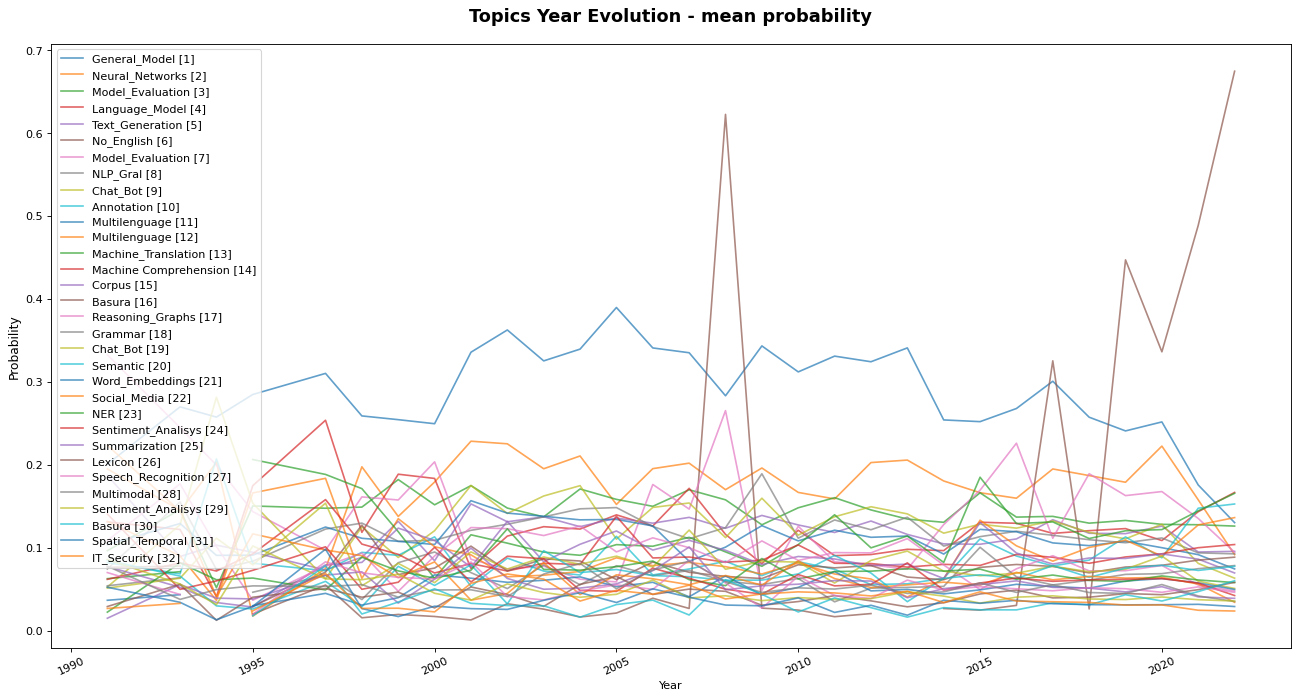

In [73]:
####### GRAFICO EVOLUCION ANUAL TOPICOS:
from matplotlib.pyplot import cm

### SELECCIONE MODELO: COLOQUE NRO DE TOPICS: 19, 32 O 16
#Model_Topics = 32   ### SELECCIONE MODELO: COLOQUE NRO DE TOPICS: 19, 32 O 16

### ACTIVE APERTURA POR GENERO:
Apertura_Genero = False 
Genders = ['male', 'female', 'andy']

### SELECCIONE AGRUPACION TOPICOS: POR NRO TOPICO GRAFICO GENSIM: "number" / POR TAG TOPICO: "tag".
Group_By_Definition = 'number' # 'number' / 'tag' ### SELECCIONE AGRUPACION TOPICOS: POR NRO TOPICO GRAFICO GENSIM: 'number' / POR TAG TOPICO: 'tag'.

viz_all = True  ### True: PARA VER TODOS LOS TOPICS. False: PARA VER SOLO TOPICS SELECCIONADOS (SELECCIONE DEBAJO POR NUMERO O POR TAG).

# SELECCIONE los Nros (del 1 al 32) de los Topicos (segun Grafico Gensim) a visualizar: SOLO DISPONIBLE PARA Group_By_Definition = 'number'
topics2viz = [15, 26, 27, 23, 2]

# SELECCIONE los Nombres (tags) de los Topicos a visualizar: SOLO DISPONIBLE PARA Group_By_Definition = 'tag'
''' NOMBRES (TAGS) DISPONIBLES: 
['Chat_Bot','Model_Evaluation','Social_Media','Speech_Recognition','Machine Comprehension','Multilenguage',
 'Machine_Translation', 'Corpus', 'No_English', 'Lexicon', 'Grammar', 'Multimodal', 'Word_Embeddings', 'Reasoning_Graphs',
 'Chat_Bot', 'General_Model', 'Language_Model', 'Text_Generation', 'IT_Security', 'Sentiment_Analisys', 'Annotation',
 'Sentiment_Analisys', 'Semantic', 'Summarization','NER', 'Neural_Networks', 'Multilenguage', 'NLP_Gral', 'Spatial_Temporal',
 'Model_Evaluation']'''
topics2viz_TAGS = ['Corpus', 'Lexicon', 'Speech_Recognition', 'NER', 'Neural_Networks'] #SELECCIONE NOMBRES (TAGS) DISPONIBLES:

#SELECCIONE metrica: 'sum' 'mean'	'median'	'std'	'count'
metric = 'mean'

#SELECCIONE PALETA DE COLORES:
paleta = 'Dark2' #'gist_rainbow', 'rainbow', 'tab20', 'Set3', 'Set1', 'Dark2'


topics_dis_agg = pd.DataFrame()
if Model_Topics == 19:
  topics_dis_agg = topics_dis_agg1

elif Model_Topics == 32:
  if Apertura_Genero == False: 
    if Group_By_Definition == 'number':
      topics_dis_agg = topics_dis_agg2
    elif Group_By_Definition == 'tag':
      topics_dis_agg = topics_dis_agg2_t
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>")
  else:
    if Group_By_Definition == 'number':
      topics_dis_agg = topics_dis_agg2_gender
    elif Group_By_Definition == 'tag':
      topics_dis_agg = topics_dis_agg2_t_gender
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>")


elif Model_Topics == 16:
  topics_dis_agg = topics_dis_agg3
else:
  print("ERROR: No Disponible Modelo con ese Nro. de Topics. ELIJA ENTRE LOS DISPONIBLES: 19, 32 o 16") 


######### ****GRAFICO:
## General params
fig = plt.figure(figsize=(20, 10), dpi=80)
ax = fig.add_subplot(1, 1, 1)

plt.title("Topics Year Evolution - "+str(metric)+" probability", fontsize=16, fontweight="bold", pad=20)
plt.ylabel("Probability", fontsize=11)
plt.xlabel('Year')
plt.xticks(rotation=25)  # Rotates X-Axis Ticks by 45-degrees

## Color params
NUM_COLORS = Model_Topics
cm = plt.get_cmap(paleta) # ver paletas en https://matplotlib.org/stable/tutorials/colors/colormaps.html
# cm = plt.get_cmap('tab20') 
if paleta != 'tab20' and paleta != 'Set3' and paleta != 'Set1'and paleta != 'Dark2' :
  ax.set_prop_cycle(color=[cm(3.*i/NUM_COLORS) for i in range(NUM_COLORS)])

## Loop    ####### XXXXX ******MODIFICAR: AGREGAR OPCION GROUPBY "TAG"!!!!****(Y AGREGAR PASTE NRO GENSIM PARA GROUPBY "NUMBER")!!!!!!!****** #######
if Apertura_Genero == False:  
  if viz_all == True:
    if Group_By_Definition == 'number':
      #for i in topics_dis_agg.topic.unique():
      for i in topics_dis_agg.Nro_Topic_pyLDAvis.unique():
        #if topics_dis_agg[topics_dis_agg['Nro_Topic_pyLDAvis'] == i]['tag'] != "Basura":
        ax.plot(
            topics_dis_agg[topics_dis_agg["Nro_Topic_pyLDAvis"] == i]["year"],
            topics_dis_agg[topics_dis_agg["Nro_Topic_pyLDAvis"] == i]["prob", metric],
            label = dict_label[i] + ' ' + '[' + str(i) + ']' ,
            alpha=0.7)
        
    elif Group_By_Definition == 'tag':
      for i in topics_dis_agg.tag.unique():
        if i != "Basura":
          ax.plot(
              topics_dis_agg[topics_dis_agg["tag"] == i]["year"],
              topics_dis_agg[topics_dis_agg["tag"] == i]["prob", metric],
              #label = dict_label[i] ,
              label = i,
              alpha=0.7)  
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>") 


  else:
    if Group_By_Definition == 'number': 
      for i in topics2viz:
        ax.plot(
            topics_dis_agg[topics_dis_agg["Nro_Topic_pyLDAvis"] == i]["year"],
            topics_dis_agg[topics_dis_agg["Nro_Topic_pyLDAvis"] == i]["prob", metric],
            label = dict_label[i] + ' ' + '[' + str(i) + ']',
            alpha=0.7)

    elif Group_By_Definition == 'tag':
      for i in topics2viz_TAGS:
        ax.plot(
            topics_dis_agg[topics_dis_agg["tag"] == i]["year"],
              topics_dis_agg[topics_dis_agg["tag"] == i]["prob", metric],
              #label = dict_label[i] ,
              label = i,
              alpha=0.7) 
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>") 

else:
  if viz_all == True:
    if Group_By_Definition == 'number':
      #for i in topics_dis_agg.topic.unique():
      for i in topics_dis_agg.Nro_Topic_pyLDAvis.unique():
        #if topics_dis_agg[topics_dis_agg['Nro_Topic_pyLDAvis'] == i]['tag'] != "Basura":
        for g in Genders:
          ax.plot(
            topics_dis_agg[(topics_dis_agg.Nro_Topic_pyLDAvis == i) & (topics_dis_agg.gender == g)]["year"],
            topics_dis_agg[(topics_dis_agg.Nro_Topic_pyLDAvis == i) & (topics_dis_agg.gender == g)]["prob", metric],
            label = str(dict_label[i]) + ' ' + '[' + str(i) + ']' + ' ' + str(g) ,
            alpha=0.7)
        
    elif Group_By_Definition == 'tag':
      for i in topics_dis_agg.tag.unique():
        for g in Genders:
          if i != "Basura": 
            ax.plot(
              topics_dis_agg[(topics_dis_agg.tag == i) & (topics_dis_agg.gender == g)]["year"],
              topics_dis_agg[(topics_dis_agg.tag == i) & (topics_dis_agg.gender == g)]["prob", metric],
              #label = dict_label[i] ,
              label = i + ' ' + str(g),
              alpha=0.7)  
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>") 


  else:
    if Group_By_Definition == 'number': 
      for i in topics2viz:
        for g in Genders:
          ax.plot(
            topics_dis_agg[(topics_dis_agg.Nro_Topic_pyLDAvis == i) & (topics_dis_agg.gender == g)]["year"],
            topics_dis_agg[(topics_dis_agg.Nro_Topic_pyLDAvis == i) & (topics_dis_agg.gender == g)]["prob", metric],
            label = str(dict_label[i]) + ' ' + '[' + str(i) + ']' + ' ' + str(g) ,
            alpha=0.7)
        
    elif Group_By_Definition == 'tag':
      for i in topics2viz_TAGS:
        for g in Genders:
          if i != "Basura": 
            ax.plot(
              topics_dis_agg[(topics_dis_agg.tag == i) & (topics_dis_agg.gender == g)]["year"],
              topics_dis_agg[(topics_dis_agg.tag == i) & (topics_dis_agg.gender == g)]["prob", metric],
              #label = dict_label[i] ,
              label = i + ' ' + str(g),
              alpha=0.7)           
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>") 


## Eliminacion de legendas duplicadas      
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
legend_without_duplicate_labels(ax)

## Display
plt.show()

In [32]:
topics_dis_agg

index  year  gender       tag  \
                                   
0      0  1991  female  Chat_Bot   
1      1  1991    male  Chat_Bot   
2      2  1993  female  Chat_Bot   
3      3  1993    male  Chat_Bot   
4      4  1994  female  Chat_Bot   
..   ...   ...     ...       ...   
77    77  2021  female  Chat_Bot   
78    78  2021    male  Chat_Bot   
79    79  2022    andy  Chat_Bot   
80    80  2022  female  Chat_Bot   
81    81  2022    male  Chat_Bot   

                                              topic_y       prob            \
                                                             sum      mean   
0   question,questions,answering,answer,qa,answers...   0.073987  0.036993   
1   question,questions,answering,answer,qa,answers...   0.233495  0.058374   
2   question,questions,answering,answer,qa,answers...   0.078349  0.026116   
3   question,questions,answering,answer,qa,answers...   0.742820  0.074282   
4   question,questions,answering,answer,qa,answers...   0.083219  0.083219   
..                                                ...        ...       ...   
77  question,questions,answering,answer,qa,answers...  13.159133  0.055524   
78  question,questions,answering,answer,qa,answers...  33.916452  0.061443   
79  question,questions,answering,answer,qa,answers...   2.789239  0.082036   
80  question,questions,answering,answer,qa,answers...   5.963338  0.051408   
81  question,questions,answering,answer,qa,answers...  13.033706  0.046716   

                              
      median       std count  
0   0.036993  0.017820     2  
1   0.048626  0.042952     4  
2   0.025370  0.011228     3  
3   0.074878  0.046565    10  
4   0.083219       NaN     1  
..       ...       ...   ...  
77  0.033030  0.057166   237  
78  0.032932  0.073968   552  
79  0.029209  0.103022    34  
80  0.031478  0.056596   116  
81  0.027878  0.062597   279  

[82 rows x 10 columns]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


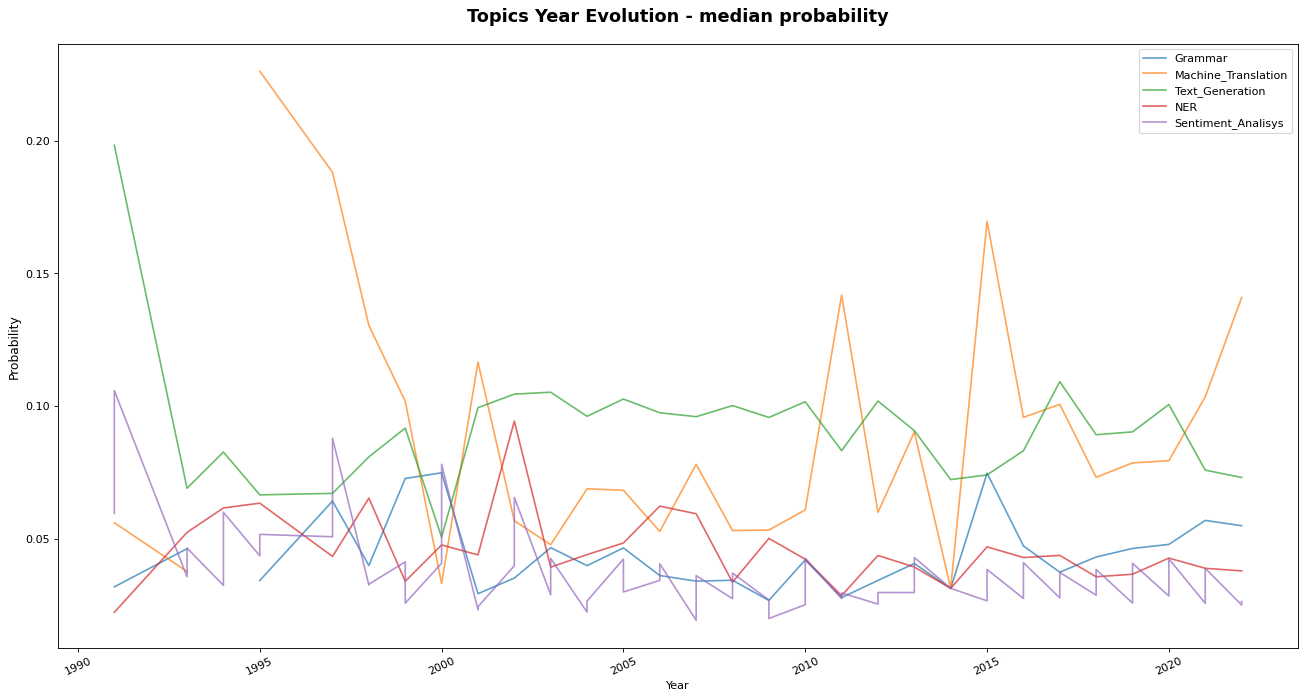

In [108]:
####### GRAFICO EVOLUCION ANUAL TOPICOS:
from matplotlib.pyplot import cm

### SELECCIONE MODELO: COLOQUE NRO DE TOPICS: 19, 32 O 16
#Model_Topics = 32   ### SELECCIONE MODELO: COLOQUE NRO DE TOPICS: 19, 32 O 16

### ACTIVE APERTURA POR GENERO:
Apertura_Genero = False 
Genders = ['male', 'female','andy']

### SELECCIONE AGRUPACION TOPICOS: POR NRO TOPICO GRAFICO GENSIM: "number" / POR TAG TOPICO: "tag".
Group_By_Definition = 'tag' # 'number' / 'tag' ### SELECCIONE AGRUPACION TOPICOS: POR NRO TOPICO GRAFICO GENSIM: 'number' / POR TAG TOPICO: 'tag'.

viz_all = False  ### True: PARA VER TODOS LOS TOPICS. False: PARA VER SOLO TOPICS SELECCIONADOS (SELECCIONE DEBAJO POR NUMERO O POR TAG).

# SELECCIONE los Nros (del 1 al 32) de los Topicos (segun Grafico Gensim) a visualizar: SOLO DISPONIBLE PARA Group_By_Definition = 'number'
topics2viz = [15, 26, 27, 23, 2]

# SELECCIONE los Nombres (tags) de los Topicos a visualizar: SOLO DISPONIBLE PARA Group_By_Definition = 'tag'
''' NOMBRES (TAGS) DISPONIBLES: 
['Chat_Bot','Model_Evaluation','Social_Media','Speech_Recognition','Machine Comprehension','Multilenguage',
 'Machine_Translation', 'Corpus', 'No_English', 'Lexicon', 'Grammar', 'Multimodal', 'Word_Embeddings', 'Reasoning_Graphs',
 'Chat_Bot', 'General_Model', 'Language_Model', 'Text_Generation', 'IT_Security', 'Sentiment_Analisys', 'Annotation',
 'Sentiment_Analisys', 'Semantic', 'Summarization','NER', 'Neural_Networks', 'Multilenguage', 'NLP_Gral', 'Spatial_Temporal',
 'Model_Evaluation']'''
#topics2viz_TAGS = ['Corpus', 'Lexicon', 'Speech_Recognition', 'NER', 'Neural_Networks'] #SELECCIONE NOMBRES (TAGS) DISPONIBLES:
topics2viz_TAGS = ['Grammar', 'Machine_Translation', 'Text_Generation', 'NER', 'Sentiment_Analisys'] #SELECCIONE NOMBRES (TAGS) DISPONIBLES:


#SELECCIONE metrica: 'sum' 'mean'	'median'	'std'	'count'
metric = 'median' #'mean' ##'sum'

#SELECCIONE PALETA DE COLORES:
paleta = 'Dark2' #'gist_rainbow', 'rainbow', 'tab20', 'Set3', 'Set1', 'Dark2'


topics_dis_agg = pd.DataFrame()
if Model_Topics == 19:
  topics_dis_agg = topics_dis_agg1

elif Model_Topics == 32:
  if Apertura_Genero == False: 
    if Group_By_Definition == 'number':
      topics_dis_agg = topics_dis_agg2
    elif Group_By_Definition == 'tag':
      topics_dis_agg = topics_dis_agg2_t
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>")
  else:
    if Group_By_Definition == 'number':
      topics_dis_agg = topics_dis_agg2_gender
    elif Group_By_Definition == 'tag':
      topics_dis_agg = topics_dis_agg2_t_gender
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>")


elif Model_Topics == 16:
  topics_dis_agg = topics_dis_agg3
else:
  print("ERROR: No Disponible Modelo con ese Nro. de Topics. ELIJA ENTRE LOS DISPONIBLES: 19, 32 o 16") 


######### ****GRAFICO:
#python -m pip install scipy
!pip install scipy
from scipy.optimize import curve_fit

## General params
fig = plt.figure(figsize=(20, 10), dpi=80)
ax = fig.add_subplot(1, 1, 1)

plt.title("Topics Year Evolution - "+str(metric)+" probability", fontsize=16, fontweight="bold", pad=20)
plt.ylabel("Probability", fontsize=11)
plt.xlabel('Year')
plt.xticks(rotation=25)  # Rotates X-Axis Ticks by 45-degrees

## Color params
NUM_COLORS = Model_Topics
cm = plt.get_cmap(paleta) #'gist_rainbow'## ver paletas en https://matplotlib.org/stable/tutorials/colors/colormaps.html
# cm = plt.get_cmap('tab20') 
if paleta != 'tab20' and paleta != 'Set3' and paleta != 'Set1'and paleta != 'Dark2' :
  ax.set_prop_cycle(color=[cm(3.*i/NUM_COLORS) for i in range(NUM_COLORS)])

## Loop    ####### XXXXX ******MODIFICAR: AGREGAR OPCION GROUPBY "TAG"!!!!****(Y AGREGAR PASTE NRO GENSIM PARA GROUPBY "NUMBER")!!!!!!!****** #######
if Apertura_Genero == False:  
  if viz_all == True:
    if Group_By_Definition == 'number':
      #for i in topics_dis_agg.topic.unique():
      for i in topics_dis_agg.Nro_Topic_pyLDAvis.unique():
        #if topics_dis_agg[topics_dis_agg['Nro_Topic_pyLDAvis'] == i]['tag'] != "Basura":
        ax.plot(
            topics_dis_agg[topics_dis_agg["Nro_Topic_pyLDAvis"] == i]["year"],
            topics_dis_agg[topics_dis_agg["Nro_Topic_pyLDAvis"] == i]["prob", metric],
            label = dict_label[i] + ' ' + '[' + str(i) + ']',
            alpha=0.7)
        
    elif Group_By_Definition == 'tag':
      for i in topics_dis_agg.tag.unique():
        if i != "Basura":
          ax.plot( #scipy.optimize.curve_fit(
              topics_dis_agg[topics_dis_agg["tag"] == i]["year"],
              topics_dis_agg[topics_dis_agg["tag"] == i]["prob", metric],
              #label = dict_label[i] ,
              label = i,
              alpha=0.7)  
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>") 


  else:
    if Group_By_Definition == 'number': 
      for i in topics2viz:
        ax.plot(
            topics_dis_agg[topics_dis_agg["Nro_Topic_pyLDAvis"] == i]["year"],
            topics_dis_agg[topics_dis_agg["Nro_Topic_pyLDAvis"] == i]["prob", metric],
            label = dict_label[i] + ' ' + '[' + str(i) + ']',
            alpha=0.7)

    elif Group_By_Definition == 'tag':
      for i in topics2viz_TAGS:
        ax.plot(
            topics_dis_agg[topics_dis_agg["tag"] == i]["year"],
              topics_dis_agg[topics_dis_agg["tag"] == i]["prob", metric],
              #label = dict_label[i] ,
              label = i,
              alpha=0.7) 
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>") 

else:
  if viz_all == True:
    if Group_By_Definition == 'number':
      #for i in topics_dis_agg.topic.unique():
      for i in topics_dis_agg.Nro_Topic_pyLDAvis.unique():
        #if topics_dis_agg[topics_dis_agg['Nro_Topic_pyLDAvis'] == i]['tag'] != "Basura":
        for g in Genders:
          ax.plot(
            topics_dis_agg[(topics_dis_agg.Nro_Topic_pyLDAvis == i) & (topics_dis_agg.gender == g)]["year"],
            topics_dis_agg[(topics_dis_agg.Nro_Topic_pyLDAvis == i) & (topics_dis_agg.gender == g)]["prob", metric],
            label = str(dict_label[i]) + ' ' + '[' + str(i) + ']' + ' ' + str(g) ,
            alpha=0.7)
        
    elif Group_By_Definition == 'tag':
      for i in topics_dis_agg.tag.unique():
        for g in Genders:
          if i != "Basura": 
            ax.plot(
              topics_dis_agg[(topics_dis_agg.tag == i) & (topics_dis_agg.gender == g)]["year"],
              topics_dis_agg[(topics_dis_agg.tag == i) & (topics_dis_agg.gender == g)]["prob", metric],
              #label = dict_label[i] ,
              label = i + ' ' + str(g),
              alpha=0.7)  
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>") 


  else:
    if Group_By_Definition == 'number': 
      for i in topics2viz:
        for g in Genders:
          ax.plot(
            topics_dis_agg[(topics_dis_agg.Nro_Topic_pyLDAvis == i) & (topics_dis_agg.gender == g)]["year"],
            topics_dis_agg[(topics_dis_agg.Nro_Topic_pyLDAvis == i) & (topics_dis_agg.gender == g)]["prob", metric],
            label = str(dict_label[i]) + ' ' + '[' + str(i) + ']'+ ' ' + str(g) ,
            alpha=0.7)
        
    elif Group_By_Definition == 'tag':
      for i in topics2viz_TAGS:
        for g in Genders:
          if i != "Basura": 
            ax.plot(
              topics_dis_agg[(topics_dis_agg.tag == i) & (topics_dis_agg.gender == g)]["year"],
              topics_dis_agg[(topics_dis_agg.tag == i) & (topics_dis_agg.gender == g)]["prob", metric],
              #label = dict_label[i] ,
              label = i + ' ' + str(g),
              alpha=0.7)           
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>") 


## Eliminacion de legendas duplicadas      
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
legend_without_duplicate_labels(ax)

## Display
plt.show()

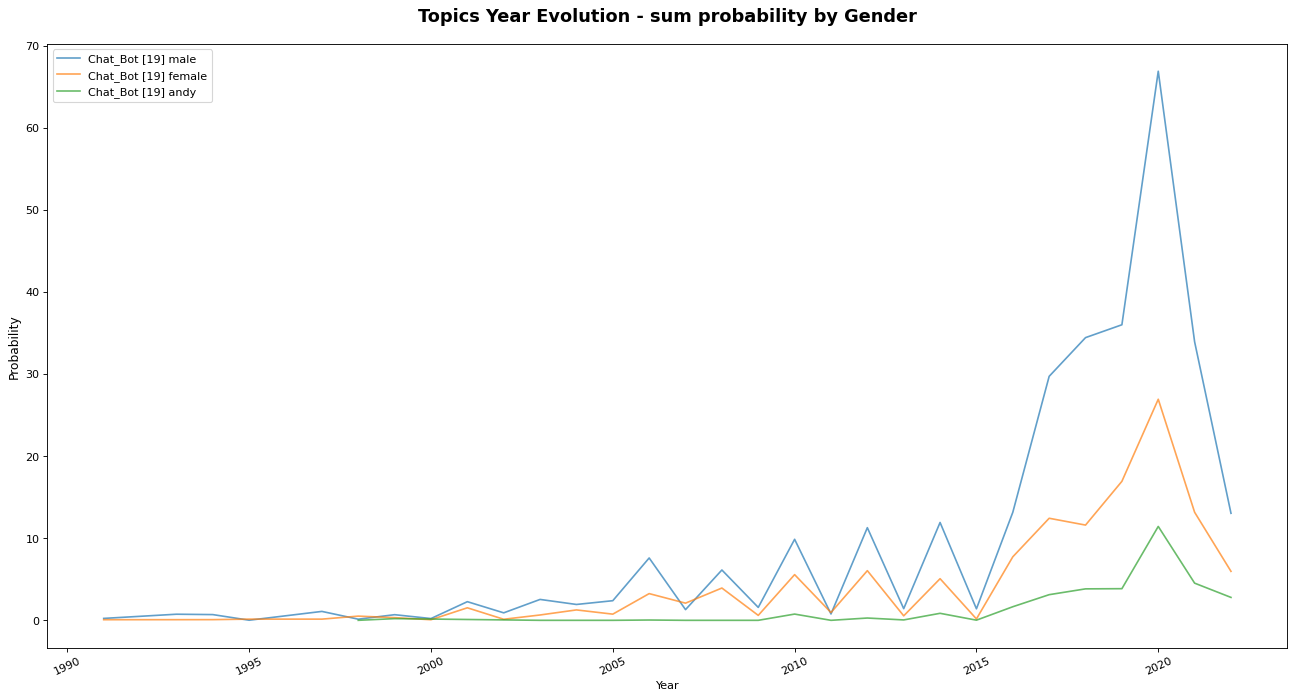

In [72]:
####### GRAFICO EVOLUCION ANUAL TOPICOS:
from matplotlib.pyplot import cm

### SELECCIONE MODELO: COLOQUE NRO DE TOPICS: 19, 32 O 16
#Model_Topics = 32   ### SELECCIONE MODELO: COLOQUE NRO DE TOPICS: 19, 32 O 16

### ACTIVE APERTURA POR GENERO:
Apertura_Genero = True 
Genders = ['male', 'female','andy']

### SELECCIONE AGRUPACION TOPICOS: POR NRO TOPICO GRAFICO GENSIM: "number" / POR TAG TOPICO: "tag".
Group_By_Definition = 'number' # 'number' / 'tag' ### SELECCIONE AGRUPACION TOPICOS: POR NRO TOPICO GRAFICO GENSIM: 'number' / POR TAG TOPICO: 'tag'.

viz_all = True  ### True: PARA VER TODOS LOS TOPICS. False: PARA VER SOLO TOPICS SELECCIONADOS (SELECCIONE DEBAJO POR NUMERO O POR TAG).

# SELECCIONE los Nros (del 1 al 32) de los Topicos (segun Grafico Gensim) a visualizar: SOLO DISPONIBLE PARA Group_By_Definition = 'number'
topics2viz = [15, 26, 27, 23, 2]

# SELECCIONE los Nombres (tags) de los Topicos a visualizar: SOLO DISPONIBLE PARA Group_By_Definition = 'tag'
''' NOMBRES (TAGS) DISPONIBLES: 
['Chat_Bot','Model_Evaluation','Social_Media','Speech_Recognition','Machine Comprehension','Multilenguage',
 'Machine_Translation', 'Corpus', 'No_English', 'Lexicon', 'Grammar', 'Multimodal', 'Word_Embeddings', 'Reasoning_Graphs',
 'Chat_Bot', 'General_Model', 'Language_Model', 'Text_Generation', 'IT_Security', 'Sentiment_Analisys', 'Annotation',
 'Sentiment_Analisys', 'Semantic', 'Summarization','NER', 'Neural_Networks', 'Multilenguage', 'NLP_Gral', 'Spatial_Temporal',
 'Model_Evaluation']'''
topics2viz_TAGS = ['Corpus', 'Lexicon', 'Speech_Recognition', 'NER', 'Neural_Networks'] #SELECCIONE NOMBRES (TAGS) DISPONIBLES:

#SELECCIONE metrica: 'sum' 'mean'	'median'	'std'	'count'
metric = 'sum'

#SELECCIONE PALETA DE COLORES:
paleta = 'Dark2' #'gist_rainbow', 'rainbow', 'tab20', 'Set3', 'Set1', 'Dark2'


topics_dis_agg = pd.DataFrame()
if Model_Topics == 19:
  topics_dis_agg = topics_dis_agg1

elif Model_Topics == 32:
  if Apertura_Genero == False: 
    if Group_By_Definition == 'number':
      topics_dis_agg = topics_dis_agg2
    elif Group_By_Definition == 'tag':
      topics_dis_agg = topics_dis_agg2_t
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>")
  else:
    if Group_By_Definition == 'number':
      topics_dis_agg = topics_dis_agg2_gender
    elif Group_By_Definition == 'tag':
      topics_dis_agg = topics_dis_agg2_t_gender
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>")


elif Model_Topics == 16:
  topics_dis_agg = topics_dis_agg3
else:
  print("ERROR: No Disponible Modelo con ese Nro. de Topics. ELIJA ENTRE LOS DISPONIBLES: 19, 32 o 16") 


######### ****GRAFICO:
## General params
fig = plt.figure(figsize=(20, 10), dpi=80)
ax = fig.add_subplot(1, 1, 1)

plt.title("Topics Year Evolution - "+str(metric)+" probability" + ' by Gender', fontsize=16, fontweight="bold", pad=20)
plt.ylabel("Probability", fontsize=11)
plt.xlabel('Year')
plt.xticks(rotation=25)  # Rotates X-Axis Ticks by 45-degrees

## Color params
NUM_COLORS = Model_Topics
cm = plt.get_cmap(paleta) # ver paletas en https://matplotlib.org/stable/tutorials/colors/colormaps.html
# cm = plt.get_cmap('tab20') 
if paleta != 'tab20' and paleta != 'Set3' and paleta != 'Set1'and paleta != 'Dark2' :
  ax.set_prop_cycle(color=[cm(3.*i/NUM_COLORS) for i in range(NUM_COLORS)])


## Loop    ####### XXXXX ******MODIFICAR: AGREGAR OPCION GROUPBY "TAG"!!!!****(Y AGREGAR PASTE NRO GENSIM PARA GROUPBY "NUMBER")!!!!!!!****** #######
if Apertura_Genero == False:  
  if viz_all == True:
    if Group_By_Definition == 'number':
      #for i in topics_dis_agg.topic.unique():
      for i in topics_dis_agg.Nro_Topic_pyLDAvis.unique():
        #if topics_dis_agg[topics_dis_agg['Nro_Topic_pyLDAvis'] == i]['tag'] != "Basura":
        ax.plot(
            topics_dis_agg[topics_dis_agg["Nro_Topic_pyLDAvis"] == i]["year"],
            topics_dis_agg[topics_dis_agg["Nro_Topic_pyLDAvis"] == i]["prob", metric],
            label = dict_label[i] + ' ' + '[' + str(i) + ']',
            alpha=0.7)
        
    elif Group_By_Definition == 'tag':
      for i in topics_dis_agg.tag.unique():
        if i != "Basura":
          ax.plot(
              topics_dis_agg[topics_dis_agg["tag"] == i]["year"],
              topics_dis_agg[topics_dis_agg["tag"] == i]["prob", metric],
              #label = dict_label[i] ,
              label = i,
              alpha=0.7)  
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>") 


  else:
    if Group_By_Definition == 'number': 
      for i in topics2viz:
        ax.plot(
            topics_dis_agg[topics_dis_agg["Nro_Topic_pyLDAvis"] == i]["year"],
            topics_dis_agg[topics_dis_agg["Nro_Topic_pyLDAvis"] == i]["prob", metric],
            label = dict_label[i] + ' ' + '[' + str(i) + ']',
            alpha=0.7)

    elif Group_By_Definition == 'tag':
      for i in topics2viz_TAGS:
        ax.plot(
            topics_dis_agg[topics_dis_agg["tag"] == i]["year"],
              topics_dis_agg[topics_dis_agg["tag"] == i]["prob", metric],
              #label = dict_label[i] ,
              label = i,
              alpha=0.7) 
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>") 

else:
  if viz_all == True:
    if Group_By_Definition == 'number':
      #for i in topics_dis_agg.topic.unique():
      for i in topics_dis_agg.Nro_Topic_pyLDAvis.unique():
        #if topics_dis_agg[topics_dis_agg['Nro_Topic_pyLDAvis'] == i]['tag'] != "Basura":
        for g in Genders:
          ax.plot(
            topics_dis_agg[(topics_dis_agg.Nro_Topic_pyLDAvis == i) & (topics_dis_agg.gender == g)]["year"],
            topics_dis_agg[(topics_dis_agg.Nro_Topic_pyLDAvis == i) & (topics_dis_agg.gender == g)]["prob", metric],
            label = str(dict_label[i])+ ' ' + '[' + str(i) + ']' + ' ' + str(g) ,
            alpha=0.7)
        
    elif Group_By_Definition == 'tag':
      for i in topics_dis_agg.tag.unique():
        for g in Genders:
          if i != "Basura": 
            ax.plot(
              topics_dis_agg[(topics_dis_agg.tag == i) & (topics_dis_agg.gender == g)]["year"],
              topics_dis_agg[(topics_dis_agg.tag == i) & (topics_dis_agg.gender == g)]["prob", metric],
              #label = dict_label[i] ,
              label = i + ' ' + str(g),
              alpha=0.7)  
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>") 


  else:
    if Group_By_Definition == 'number': 
      for i in topics2viz:
        for g in Genders:
          ax.plot(
            topics_dis_agg[(topics_dis_agg.Nro_Topic_pyLDAvis == i) & (topics_dis_agg.gender == g)]["year"],
            topics_dis_agg[(topics_dis_agg.Nro_Topic_pyLDAvis == i) & (topics_dis_agg.gender == g)]["prob", metric],
            label = str(dict_label[i]) + ' ' + '[' + str(i) + ']'+ ' ' + str(g) ,
            alpha=0.7)
        
    elif Group_By_Definition == 'tag':
      for i in topics2viz_TAGS:
        for g in Genders:
          if i != "Basura": 
            ax.plot(
              topics_dis_agg[(topics_dis_agg.tag == i) & (topics_dis_agg.gender == g)]["year"],
              topics_dis_agg[(topics_dis_agg.tag == i) & (topics_dis_agg.gender == g)]["prob", metric],
              #label = dict_label[i] ,
              label = i + ' ' + str(g),
              alpha=0.7)           
    else:
      print("ERROR: <Group_By_Definition inválido. SELECCIONE: 'number' O 'tag'>") 


## Eliminacion de legendas duplicadas      
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
legend_without_duplicate_labels(ax)

## Display
plt.show()

In [ ]:
topics_dis_agg.to_csv('topic_distribution_year.csv', index = False)
files.download('/content/topic_distribution_year.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>